## HGCA acceleration

In [106]:
hg = Table.read("../data/HGCA_vDR2_corrected.fits").to_pandas()

In [107]:
# Calculate dx and chi^2 = dx^T C dx
tmp1 = hg[["pmra_gaia_error", "pmdec_gaia_error", "pmra_pmdec_gaia"]]
tmp1.columns = tmp1.columns.str.replace("_gaia", "")
tmp1 = tmp1.rename(columns={"pmra_pmdec": "pmra_pmdec_corr"})

tmp2 = hg[["pmra_hip_error", "pmdec_hip_error", "pmra_pmdec_hip"]]
tmp2.columns = tmp2.columns.str.replace("_hip", "")
tmp2 = tmp2.rename(columns={"pmra_pmdec": "pmra_pmdec_corr"})

cov_delta_pm = tmp1.g.make_cov(["pmra", "pmdec"]) + tmp2.g.make_cov(["pmra", "pmdec"])

delta_pm = (
    hg[["pmra_gaia", "pmdec_gaia"]].values - hg[["pmra_hip", "pmdec_hip"]].values
)  # (N, 2)
diff = np.einsum("ni,nij,nj->n", delta_pm, np.linalg.inv(cov_delta_pm), delta_pm)
hg["chi2"] = diff
hg["delta_pm"] = np.linalg.norm(delta_pm, axis=1)

In [74]:
hy_dr2_hg = pd.merge(hy_dr2[['source_id']], hg.reset_index(), left_on='source_id', right_on='gaia_source_id',)
print(len(hy_dr2_hg))

116


In [22]:
leao = pd.read_csv("../data/leao_table.csv", sep=" ", skipinitialspace=True)
leao_diff = leao.merge(hg[['chi2', 'hip_id', 'delta_pm']], left_on="HIP", right_on="hip_id")
print(np.sum(leao_diff['chi2']>10))
leao_diff.sort_values('chi2', ascending=False)[['hip_id', 'Flag', 'chi2', 'delta_pm', 'RA', 'Dec']].head(n=10)

5


,hip_id,Flag,chi2,delta_pm,RA,Dec
4,19781,0,31.196661,5.634340,63.6073,14.6250
18,22380,0,26.574093,6.872383,72.2651,18.6411
65,20741,BY,22.028476,5.100405,66.6676,16.7468
16,21099,0,22.019905,7.489753,67.8159,20.1330
12,20850,0,10.275002,4.896954,67.0189,13.8679
67,20899,BY,7.703394,3.106769,67.2017,17.2853
52,22654,1,6.887780,4.059011,73.0984,18.9968
56,19786,BY,6.267399,3.762597,63.6141,12.4353
59,20082,BY,6.184200,5.446793,64.5808,16.0882
61,20237,BY,5.432824,2.054084,65.0537,19.2336


In [16]:
from scipy.stats import chi2

6 17 116
0 5 70


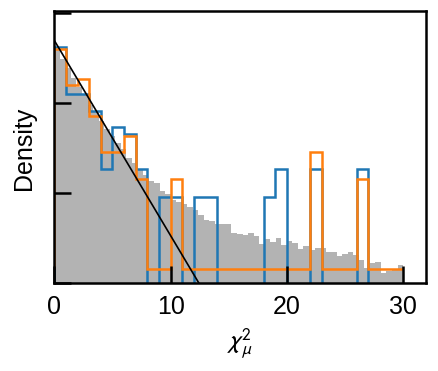

In [71]:
fig, ax = plt.subplots(figsize=(4, 3))
ax.hist(
    hg["chi2"],
    bins=np.linspace(0, 30, 64),
    log=True,
    density=True,
    color="0.7",
    label="entire HG",
)

for dset in (hy_dr2_hg, leao_diff):
    sns.distplot(
        dset["chi2"],
        bins=np.linspace(0, 30, 31),
        hist_kws=dict(log=True, density=True, histtype="step", lw=1.5, alpha=1),
        kde=False
    )
xaxis_limit = ax.get_xlim()[1]
for dset in (hy_dr2_hg, leao_diff):
    n_beyond_limit = (dset['chi2']>xaxis_limit).sum()
    n_above_thresh = (dset['chi2']>10).sum()
    print(n_beyond_limit, n_above_thresh, len(dset))

x = np.linspace(0, 30, 31)
plt.plot(x, chi2.pdf(x, 2), c="k", lw=1)

plt.ylim(1e-3)
plt.xlim(0, 32)
ax.set_xlabel(r"$\chi^2_\mu$")
ax.set_ylabel("Density")
ax.yaxis.set_major_formatter(plt.matplotlib.ticker.NullFormatter())

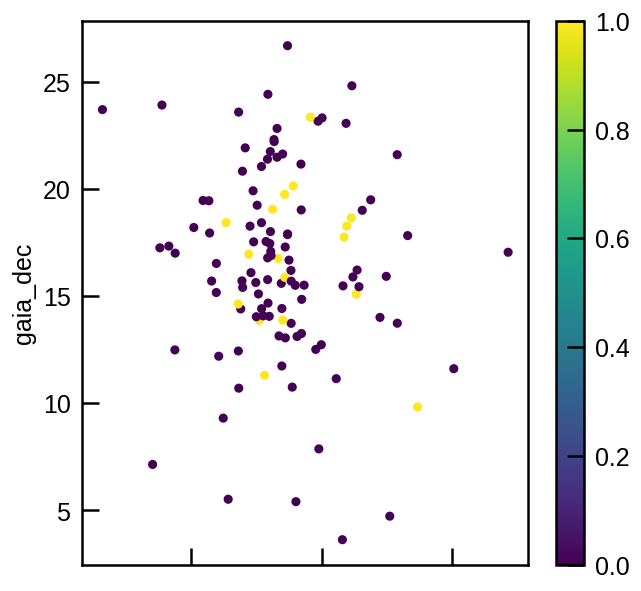

In [32]:
hg_hy_dr2.plot.scatter(
    "gaia_ra", "gaia_dec", c=hg_hy_dr2['chi2']>10, cmap='viridis'
)